## Deep Learning
# Lab Session 3 - 3 Hours
## Long Short Term Memory (LSTM) for Language Modeling

### Student 1: Collura  
### Student 2: Spano
 
 
In this Lab Session,  you will build and train a Recurrent Neural Network, based on Long Short-Term Memory (LSTM) units for next word prediction task. 

Answers and experiments should be made by groups of one or two students. Each group should fill and run appropriate notebook cells. 
Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an pdf document using print as PDF (Ctrl+P). Do not forget to run all your cells before generating your final report and do not forget to include the names of all participants in the group. The lab session should be completed by June 9th 2017.

Send you pdf file to benoit.huet@eurecom.fr and olfa.ben-ahmed@eurecom.fr using **[DeepLearning_lab3]** as Subject of your email.

#  Introduction

You will train a LSTM to predict the next word using a sample short story. The LSTM will learn to predict the next item of a sentence from the 3 previous items (given as input). Ponctuation marks are considered as dictionnary items so they can be predicted too. Figure 1 shows the LSTM and the process of next word prediction. 

<img src="lstm.png" height="370" width="370"> 


Each word (and ponctuation) from text sentences is encoded by a unique integer. The integer value corresponds to the index of the corresponding word (or punctuation mark) in the dictionnary. The network output is a one-hot-vector indicating the index of the predicted word in the reversed dictionnary (Section 1.2). For example if the prediction is 86, the predicted word will be "company". 



You will use a sample short story from Aesop’s Fables (http://www.taleswithmorals.com/) to train your model. 


<font size="3" face="verdana" > <i> "There was once a young Shepherd Boy who tended his sheep at the foot of a mountain near a dark forest.

It was rather lonely for him all day, so he thought upon a plan by which he could get a little company and some excitement.
He rushed down towards the village calling out "Wolf, Wolf," and the villagers came out to meet him, and some of them stopped with him for a considerable time.
This pleased the boy so much that a few days afterwards he tried the same trick, and again the villagers came to his help.
But shortly after this a Wolf actually did come out from the forest, and began to worry the sheep, and the boy of course cried out "Wolf, Wolf," still louder than before.
But this time the villagers, who had been fooled twice before, thought the boy was again deceiving them, and nobody stirred to come to his help.
So the Wolf made a good meal off the boy's flock, and when the boy complained, the wise man of the village said:
"A liar will not be believed, even when he speaks the truth."  "</i> </font>.    







Start by loading the necessary libraries and resetting the default computational graph. For more details about the rnn packages, we suggest you to take a look at https://www.tensorflow.org/api_guides/python/contrib.rnn

In [1]:
import numpy as np
import collections # used to build the dictionary
import random
import time
import pickle # may be used to save your model 
%matplotlib inline
import matplotlib.pyplot as plt
#Import Tensorflow and rnn
import tensorflow as tf
from tensorflow.contrib import rnn  

# Target log path
logs_path = 'lstm_words'
writer = tf.summary.FileWriter(logs_path)

# Next-word prediction task

## Part 1: Data  preparation

### 1.1. Loading data

Load and split the text of our story

In [2]:
def load_data(filename):
    with open(filename) as f:
        data = f.readlines()
    data = [x.strip().lower() for x in data]
    data = [data[i].split() for i in range(len(data))]
    data = np.array(data)
    data = np.reshape(data, [-1, ])
    print(data)
    return data

#Run the cell 
train_file ='data/story.txt'
train_data = load_data(train_file)
print("Loaded training data...")
print(len(train_data))

['there' 'was' 'once' 'a' 'young' 'shepherd' 'boy' 'who' 'tended' 'his'
 'sheep' 'at' 'the' 'foot' 'of' 'a' 'mountain' 'near' 'a' 'dark' 'forest'
 '.' 'it' 'was' 'rather' 'lonely' 'for' 'him' 'all' 'day' ',' 'so' 'he'
 'thought' 'upon' 'a' 'plan' 'by' 'which' 'he' 'could' 'get' 'a' 'little'
 'company' 'and' 'some' 'excitement' '.' 'he' 'rushed' 'down' 'towards'
 'the' 'village' 'calling' 'out' 'wolf' ',' 'wolf' ',' 'and' 'the'
 'villagers' 'came' 'out' 'to' 'meet' 'him' ',' 'and' 'some' 'of' 'them'
 'stopped' 'with' 'him' 'for' 'a' 'considerable' 'time' '.' 'this'
 'pleased' 'the' 'boy' 'so' 'much' 'that' 'a' 'few' 'days' 'afterwards'
 'he' 'tried' 'the' 'same' 'trick' ',' 'and' 'again' 'the' 'villagers'
 'came' 'to' 'his' 'help' '.' 'but' 'shortly' 'after' 'this' 'a' 'wolf'
 'actually' 'did' 'come' 'out' 'from' 'the' 'forest' ',' 'and' 'began' 'to'
 'worry' 'the' 'sheep,' 'and' 'the' 'boy' 'of' 'course' 'cried' 'out'
 'wolf' ',' 'wolf' ',' 'still' 'louder' 'than' 'before' '.' 'but' 't

### 1.2. Symbols encoding

The LSTM input's can only be numbers. A way to convert words (symbols or any items) to numbers is to assign a unique integer to each word. This process is often based on frequency of occurrence for efficient coding purpose.

Here, we define a function to build an indexed word dictionary (word->number). The "build_vocabulary" function builds both:

- Dictionary : used for encoding words to numbers for the LSTM inputs 
- Reverted dictionnary : used for decoding the outputs of the LSTM into words (and punctuation).

For example, in the story above, we have **113** individual words. The "build_vocabulary" function builds a dictionary with the following entries ['the': 0], [',': 1], ['company': 85],...


In [3]:
def build_vocabulary(words):
    count = collections.Counter(words).most_common()
    dic= dict()
    for word, _ in count:
        dic[word] = len(dic)
    reverse_dic = dict(zip(dic.values(), dic.keys()))
    return dic, reverse_dic

Run the cell below to display the vocabulary

In [4]:
dictionary, reverse_dictionary = build_vocabulary(train_data)
vocabulary_size = len(dictionary) 
print("Dictionary size (Vocabulary size) = ", vocabulary_size)
print("\n")
print("Dictionary : \n")
print(dictionary)
print("\n")
print("Reverted Dictionary : \n" )
print(reverse_dictionary)

Dictionary size (Vocabulary size) =  113


Dictionary : 

{'this': 11, 'out': 9, 'truth': 32, 'towards': 33, 'mountain': 34, 'near': 35, 'it': 36, 'from': 37, 'but': 23, 'again': 17, 'began': 38, 'help': 18, 'meet': 75, 'some': 19, 'foot': 40, 'excitement': 43, 'calling': 90, 'upon': 44, 'when': 20, 'down': 45, 'speaks': 42, 'stopped': 47, 'few': 48, 'complained': 49, 'considerable': 50, 'plan': 46, 'pleased': 52, 'dark': 53, 'cried': 54, 'nobody': 55, 'once': 68, 'them': 21, 'sheep,': 56, "boy's": 59, 'louder': 60, 'wolf': 5, 'get': 106, 'was': 12, 'that': 62, 'than': 58, 'of': 10, 'at': 57, 'fooled': 63, 'did': 64, 'off': 73, 'worry': 65, 'deceiving': 108, 'with': 66, 'course': 67, 'who': 31, 'days': 70, 'so': 13, 'flock': 71, 'lonely': 72, 'not': 41, 'been': 74, 'stirred': 39, '.': 4, 'after': 76, 'his': 14, 'a': 2, 'for': 24, 'and': 3, 'village': 25, 'had': 77, 'came': 26, 'little': 78, 'young': 79, 'same': 80, 'rather': 81, 'shortly': 110, 'forest': 27, 'tended': 82, ':': 83, 'tri

## Part 2 : LSTM Model in TensorFlow

Since you have defined how the data will be modeled, you are now to develop an LSTM model to predict the word of following a sequence of 3 words. 

### 2.1. Model definition

Define a 2-layers LSTM model.  

For this use the following classes from the tensorflow.contrib library:

- rnn.BasicLSTMCell(number of hidden units) 
- rnn.static_rnn(rnn_cell, data, dtype=tf.float32)
- rnn.MultiRNNCell(,)


You may need some tensorflow functions (https://www.tensorflow.org/api_docs/python/tf/) :
- tf.split
- tf.reshape 
- ...




In [5]:
def lstm_model(x, w, b, n_hidden=265, n_input=3, n_layers=2):
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(x, n_input, 1)

    # n LSTM with n_hidden units.
    rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(n_hidden) for _ in range(n_layers)])

    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    
    return tf.matmul(outputs[-1], w['out']) + b['out']

Training Parameters, constants the Loss/Cost and optimizer

In [10]:
def define_graph(learning_rate=0.001, n_input=3, n_layers=2, n_hidden=64):
    """
    # Training Parameters
    learning_rate = 0.001
    epochs = 50000
    display_step = 1000
    n_input = 3
    n_layers = 2
    
    # For each LSTM cell that you initialise, supply a value for the hidden dimension, number of units in LSTM cell
    n_hidden = 64
    """
    tf.reset_default_graph()

    model_path = 'lstm_model/lstm-%d-%d' % (n_layers, n_input)

    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocabulary_size])

    # LSTM  weights and biases
    weights = {'out': tf.Variable(tf.random_normal([n_hidden, vocabulary_size]))}
    biases = {'out': tf.Variable(tf.random_normal([vocabulary_size]))}

    # build the model
    pred = lstm_model(x, weights, biases, n_hidden=n_hidden, n_input=n_input, n_layers=n_layers)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))  # Cross Entropy loss
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)  # use RMSProp Optimizer

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, model_path

We give you here the Test Function

In [11]:
#run the cell
def test(sentence, session, verbose=False):
    sentence = sentence.strip()
    words = sentence.split(' ')
    if len(words) != n_input:
        print("sentence length should be equal to", n_input, "!")
    try:
        symbols_inputs = [dictionary[str(words[i - n_input])] for i in range(n_input)]
        keys = np.reshape(np.array(symbols_inputs), [-1, n_input, 1])
        onehot_pred = session.run(pred, feed_dict={x: keys})
        onehot_pred_index = int(tf.argmax(onehot_pred, 1).eval())
        words.append(reverse_dictionary[onehot_pred_index])
        sentence = " ".join(words)
        if verbose:
            print(sentence)
        return reverse_dictionary[onehot_pred_index]
    except:
        print(" ".join(["Word", words[i - n_input], "not in dictionary"]))

## Part 3 : LSTM Training  

In the Training process, at each epoch, 3 words are taken from the training data, encoded to integer to form the input vector. The training labels are one-hot vector encoding the word that comes after the 3 inputs words. Display the loss and the training accuracy every 1000 iteration. Save the model at the end of training in the **lstm_model** folder

In [12]:
def lstm_training(x, y, weights, biases, pred, cost, optimizer, correct_pred, 
                  accuracy, model_path, n_input, epochs=30000, display_step=1000):
    # Initializing the variables
    start_time = time.time()
    init = tf.global_variables_initializer()
    model_saver = tf.train.Saver()
    
    losses = []
    accuracies = []

    # Launch the graph
    with tf.Session() as session:
        session.run(init)

        print("Start Training")
        step = 0
        offset = random.randint(0, n_input + 1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        writer.add_graph(session.graph)

        for step in range(epochs):
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(train_data) - end_offset):
                offset = random.randint(0, n_input + 1)

            symbols_in_keys = [[dictionary[str(train_data[i])]] for i in range(offset, offset+n_input)]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = np.zeros([vocabulary_size], dtype=float)
            symbols_out_onehot[dictionary[str(train_data[offset+n_input])]] = 1.0
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            if (step + 1) % display_step == 0:    
                losses.append(loss_total / display_step)
                accuracies.append(100 * acc_total / display_step)
                
                print("Iter = " + str(step + 1) + ", Average Loss = " + \
                      "{:.6f}".format(loss_total / display_step) + ", Average Accuracy = " + \
                      "{:.2f}%".format(100 * acc_total / display_step))
                acc_total = 0
                loss_total = 0
                symbols_in = [train_data[i] for i in range(offset, offset + n_input)]
                symbols_out = train_data[offset + n_input]
                symbols_out_pred = reverse_dictionary[int(tf.argmax(onehot_pred, 1).eval())]
                print("%s - [%s] vs [%s]" % (symbols_in,symbols_out,symbols_out_pred))
            step += 1
            offset += n_input + 1

        print("End Of training Finished!")
        print("time: ",time.time() - start_time)
        print("For tensorboard visualisation run on command line.")
        print("\ttensorboard --logdir=%s" % (logs_path))
        print("and point your web browser to the returned link")

        # save your model 
        model_saver.save(session, model_path)
        print("Model saved")
        
        return losses, accuracies

In [13]:
n_input=3
n_layers=2
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, correct_pred, 
                                   accuracy, path, epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.463258, Average Accuracy = 6.50%
['be', 'believed', ','] - [even] vs [when]
Iter = 2000, Average Loss = 3.591176, Average Accuracy = 14.00%
['said', ':', 'a'] - [liar] vs [foot]
Iter = 3000, Average Loss = 2.974352, Average Accuracy = 27.00%
['be', 'believed', ','] - [even] vs [boy's]
Iter = 4000, Average Loss = 2.941588, Average Accuracy = 23.60%
['he', 'speaks', 'the'] - [truth] vs [boy]
Iter = 5000, Average Loss = 1.900931, Average Accuracy = 49.00%
['once', 'a', 'young'] - [shepherd] vs [days]
Iter = 6000, Average Loss = 2.187606, Average Accuracy = 40.80%
['young', 'shepherd', 'boy'] - [who] vs [the]
Iter = 7000, Average Loss = 1.711673, Average Accuracy = 52.10%
['once', 'a', 'young'] - [shepherd] vs [shepherd]
Iter = 8000, Average Loss = 1.251597, Average Accuracy = 64.90%
['at', 'the', 'foot'] - [of] vs [of]
Iter = 9000, Average Loss = 1.259011, Average Accuracy = 66.70%
['a', 'mountain', 'near'] - [a] vs [.]
Iter = 10000, Average Lo

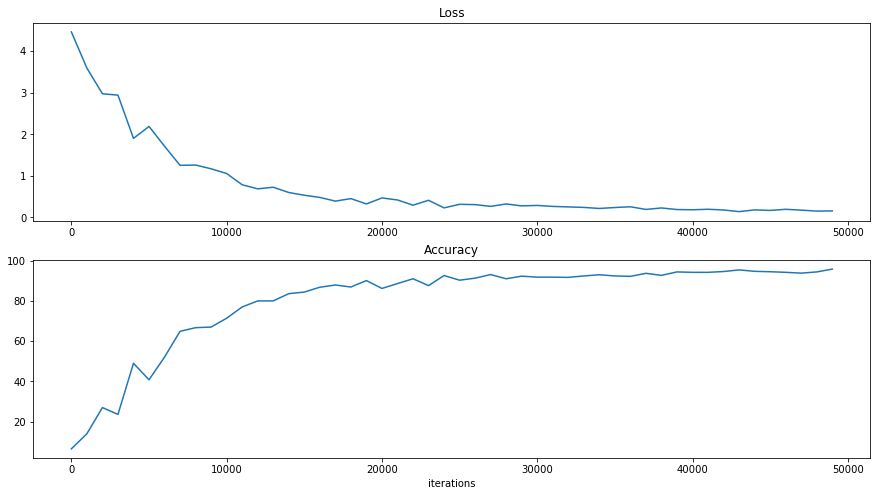

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(np.arange(0,50000, 1000), losses)
ax1.set_title('Loss')
ax2.plot(np.arange(0,50000, 1000), accuracies)
ax2.set_title('Accuracy')
ax2.set_xlabel('iterations')
plt.show()

## Part 4 : Test your model 

### 3.1. Next word prediction

Load your model (using the model_saved variable given in the training session) and test the sentences :
- 'get a little' 
- 'nobody tried to'
- Try with other sentences using words from the story's vocabulary. 

In addition to the two sentences proposed, we decided to test our predictions on 10 random 3-word-sentences taken from the original text.

In [21]:
def next_word_prediction(model_path, n_input, sentences=None):
    model_saver = tf.train.Saver()
    with tf.Session() as session:
        model_saver.restore(session, model_path)

        if sentences is not None:
            for sentence in sentences:
                test(sentence, session, True)
            print('\n')

        # Take n_input + 1 word, this way we can compare the generated word with the real one
        sentences = [train_data[n:n + n_input + 1] 
                     for n in np.random.randint(0, len(train_data) - n_input - 1, 10)]
        for sentence in sentences:
            predicted = test(' '.join(sentence[:-1]), session, True)
            print(' Predicted word:', predicted, '\n Word from text:', sentence[-1])
            
next_word_prediction(path, n_input, sentences=['get a little', 'nobody tried to'])

INFO:tensorflow:Restoring parameters from lstm_model/lstm-2-3
get a little company
nobody tried to who


at the foot of
 Predicted word: of 
 Word from text: of
could get a little
 Predicted word: little 
 Word from text: little
, and some the
 Predicted word: the 
 Word from text: of
, so he thought
 Predicted word: thought 
 Word from text: thought
before , thought the
 Predicted word: the 
 Word from text: the
mountain near a dark
 Predicted word: dark 
 Word from text: dark
, and the villagers
 Predicted word: villagers 
 Word from text: villagers
. but this time
 Predicted word: time 
 Word from text: time
and some excitement .
 Predicted word: . 
 Word from text: .
he rushed down towards
 Predicted word: towards 
 Word from text: towards


<div class='alert alert-warning'>
As we can see, the predicted word is most of the time equal to the actual word following our 3-word sentence.
</div>

### 3.2. More fun with the Fable Writer !

You will use the RNN/LSTM model learned in the previous question to create a
new story/fable.
For this you will choose 3 words from the dictionary which will start your
story and initialize your network. Using those 3 words the RNN will generate
the next word or the story. Using the last 3 words (the newly predicted one
and the last 2 from the input) you will use the network to predict the 5
word of the story.. and so on until your story is 5 sentence long. 
Make a point at the end of your story. 
To implement that, you will use the test function. 

In [23]:
def generate_fable(model_path, n_input):
    model_saver = tf.train.Saver()
    with tf.Session() as session:
        model_saver.restore(session, model_path)
        n = np.random.randint(0, len(train_data) - n_input)
        words = train_data[n:n + n_input].tolist()
        while words.count('.') < 5 and len(words) < 1000:  # set an upper bound on iterations
            sentence = ' '.join(words[-n_input:])
            words.append(test(sentence, session))

    if words[-1] != '.':
        words.append('.')
    return ' '.join(words)

print(generate_fable(path, n_input))

INFO:tensorflow:Restoring parameters from lstm_model/lstm-2-3
come to his help . but shortly after this a wolf actually did come out from the forest calling : a so excitement . his this . a wolf , still louder than before . but this time the villagers , who had been fooled the foot of a mountain near a dark forest .


<div class='alert alert-warning'>
As we can see, the story makes little sense in english, and it doesn't precisely follow the original one either. This is due to the fact that maybe the window of words to look at to make the prediction is too short, so sometimes the algorithm is able to predict the correct next word, like for example: come to his --> help, to his help --> . but not always, and that takes us off-track. We expect that by increasing the window of words we will increase the chances of getting the original text as a result.
</div>

### 3.3. Play with number of inputs

The number of input in our example is 3, see what happens when you use other number (1 and 5)

#### 3.3.1 Number of inputs = 5

In [24]:
n_input=5
n_layers=2
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, 
                                  correct_pred, accuracy, path,
                                  epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.466149, Average Accuracy = 6.70%
[',', 'and', 'nobody', 'stirred', 'to'] - [come] vs [him]
Iter = 2000, Average Loss = 3.353745, Average Accuracy = 23.10%
['and', 'began', 'to', 'worry', 'the'] - [sheep,] vs [and]
Iter = 3000, Average Loss = 2.598150, Average Accuracy = 39.20%
['a', 'considerable', 'time', '.', 'this'] - [pleased] vs [pleased]
Iter = 4000, Average Loss = 2.075831, Average Accuracy = 48.40%
['him', 'all', 'day', ',', 'so'] - [he] vs [he]
Iter = 5000, Average Loss = 1.340913, Average Accuracy = 64.70%
['shepherd', 'boy', 'who', 'tended', 'his'] - [sheep] vs [meet]
Iter = 6000, Average Loss = 0.856227, Average Accuracy = 76.40%
['but', 'this', 'time', 'the', 'villagers'] - [,] vs [,]
Iter = 7000, Average Loss = 0.624746, Average Accuracy = 83.50%
['the', 'boy', 'so', 'much', 'that'] - [a] vs [a]
Iter = 8000, Average Loss = 0.408925, Average Accuracy = 89.70%
['him', 'all', 'day', ',', 'so'] - [he] vs [he]
Iter = 9000, Average L

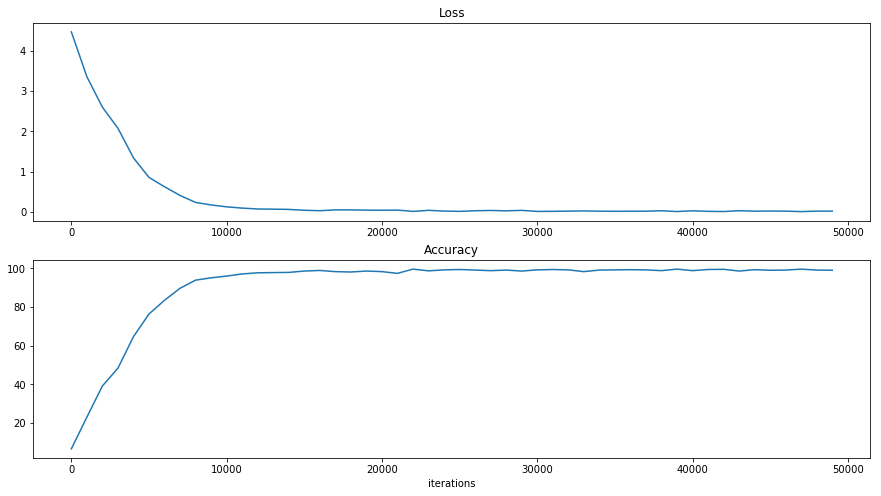

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(np.arange(0,50000, 1000), losses)
ax1.set_title('Loss')
ax2.plot(np.arange(0,50000, 1000), accuracies)
ax2.set_title('Accuracy')
ax2.set_xlabel('iterations')
plt.show()

<div class='alert alert-warning'>
In this case, we notice that we converge pretty easily to a very low loss value and almost a 100% accuracy in a small set of iterations.
</div>

In [26]:
next_word_prediction(path, n_input)

INFO:tensorflow:Restoring parameters from lstm_model/lstm-2-5
so the wolf made a good
 Predicted word: good 
 Word from text: good
still louder than before . but
 Predicted word: but 
 Word from text: but
villagers , who had been fooled
 Predicted word: fooled 
 Word from text: fooled
from the forest , and began
 Predicted word: began 
 Word from text: began
time . this pleased the boy
 Predicted word: boy 
 Word from text: boy
of course cried out wolf ,
 Predicted word: , 
 Word from text: ,
when the boy complained , the
 Predicted word: the 
 Word from text: the
time the villagers , who had
 Predicted word: had 
 Word from text: had
wolf actually did come out from
 Predicted word: from 
 Word from text: from
out to meet him , and
 Predicted word: and 
 Word from text: and


In [27]:
print(generate_fable(path, n_input))

INFO:tensorflow:Restoring parameters from lstm_model/lstm-2-5
trick , and again the villagers came to his help . but shortly after this a wolf actually did come out from the forest , and began to worry the sheep, and the boy of course cried out wolf , wolf , and the villagers came out to meet him , and some of them stopped with him for a considerable time . this pleased the boy so much that a few days afterwards he tried the same trick , and again the villagers came to his help . but shortly after this a wolf actually did come out from the forest , and began to worry the sheep, and the boy of course cried out wolf , wolf , and the villagers came out to meet him , and some of them stopped with him for a considerable time . this pleased the boy so much that a few days afterwards he tried the same trick , and again the villagers came to his help .


<font size="3" face="verdana" > <i> "There was once a young Shepherd Boy who tended his sheep at the foot of a mountain near a dark forest.

It was rather lonely for him all day, so he thought upon a plan by which he could get a little company and some excitement.
He rushed down towards the village calling out "Wolf, Wolf," and the villagers came out to meet him, and some of them stopped with him for a considerable time.
This pleased the boy so much that a few days afterwards he tried the same trick, and again the villagers came to his help.
But shortly after this a Wolf actually did come out from the forest, and began to worry the sheep, and the boy of course cried out "Wolf, Wolf," still louder than before.
But this time the villagers, who had been fooled twice before, thought the boy was again deceiving them, and nobody stirred to come to his help.
So the Wolf made a good meal off the boy's flock, and when the boy complained, the wise man of the village said:
"A liar will not be believed, even when he speaks the truth."  "</i> </font>.    







<div class='alert alert-warning'>
As we can see the text we obtain is still not exactly the same as the original. We believe this is due to the fact that the window is still to small to actually have the exact match. By comparing this with the previous result though, we can see that we made considerable improvements, given that we manage to correctly predict the text until "Wolf, Wolf", where unfortunately we never find the continuation to be "still louder than before" and we therefore get stuck in a loop.
</div>

#### 3.3.2 Number of inputs = 1

In [28]:
n_input=1
n_layers=2
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, 
                                  correct_pred, accuracy, path,
                                  epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.572109, Average Accuracy = 4.10%
['so'] - [much] vs [,]
Iter = 2000, Average Loss = 4.191515, Average Accuracy = 5.60%
['help'] - [.] vs [.]
Iter = 3000, Average Loss = 4.153628, Average Accuracy = 6.10%
['.'] - [he] vs [wolf]
Iter = 4000, Average Loss = 3.967120, Average Accuracy = 8.20%
['wolf'] - [,] vs [wolf]
Iter = 5000, Average Loss = 4.091443, Average Accuracy = 9.40%
['his'] - [sheep] vs [,]
Iter = 6000, Average Loss = 3.976566, Average Accuracy = 11.00%
['the'] - [same] vs [boy]
Iter = 7000, Average Loss = 3.941521, Average Accuracy = 10.90%
['made'] - [a] vs [,]
Iter = 8000, Average Loss = 3.712799, Average Accuracy = 11.60%
['he'] - [rushed] vs [his]
Iter = 9000, Average Loss = 3.941796, Average Accuracy = 10.10%
['course'] - [cried] vs [a]
Iter = 10000, Average Loss = 3.846914, Average Accuracy = 10.40%
['was'] - [once] vs [the]
Iter = 11000, Average Loss = 3.990972, Average Accuracy = 10.20%
['few'] - [days] vs [a]
Iter = 12000,

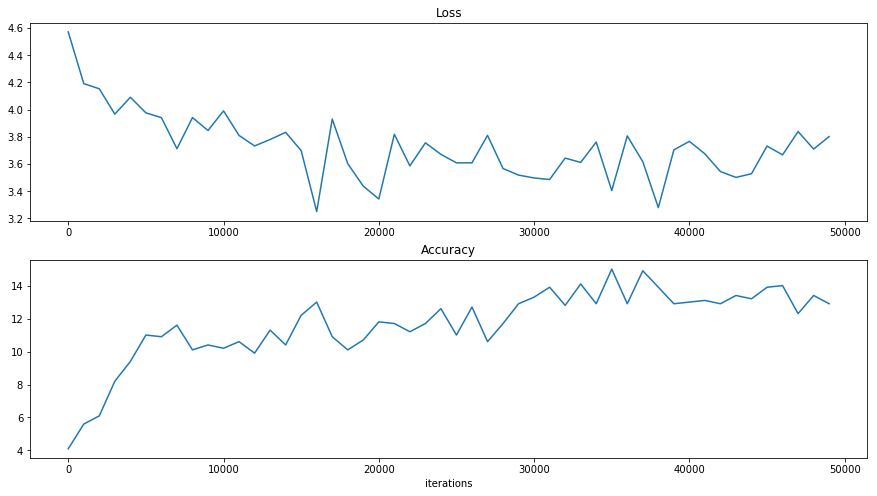

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(np.arange(0,50000, 1000), losses)
ax1.set_title('Loss')
ax2.plot(np.arange(0,50000, 1000), accuracies)
ax2.set_title('Accuracy')
ax2.set_xlabel('iterations')
plt.show()

In [30]:
next_word_prediction(path, n_input)

INFO:tensorflow:Restoring parameters from lstm_model/lstm-2-1
before .
 Predicted word: . 
 Word from text: ,
a plan
 Predicted word: plan 
 Word from text: plan
even the
 Predicted word: the 
 Word from text: when
forest .
 Predicted word: . 
 Word from text: ,
flock the
 Predicted word: the 
 Word from text: ,
did the
 Predicted word: the 
 Word from text: come
said and
 Predicted word: and 
 Word from text: :
, and
 Predicted word: and 
 Word from text: and
meal a
 Predicted word: a 
 Word from text: off
after the
 Predicted word: the 
 Word from text: this


<div class='alert alert-warning'>
As expected given the low accuracy obtained in the training phase, we do not have good guesses on the next words in this case.
</div>

In [32]:
print(generate_fable(path, n_input))

INFO:tensorflow:Restoring parameters from lstm_model/lstm-2-1
to , and some the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers the villagers 

<div class='alert alert-warning'>
This time we are clearly stuck in a loop and we keep printing the same sentences over again. This is due to the fact that the window is too small, and it predicts only based on the last word: every time it finds "the" for example, it will always predict "villagers" as the following word. 

#### 3.3.3 Number of inputs = 6

In [33]:
n_input=6
n_layers=2
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, 
                                  correct_pred, accuracy, path,
                                  epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.506409, Average Accuracy = 7.10%
['time', 'the', 'villagers', ',', 'who', 'had'] - [been] vs [a]
Iter = 2000, Average Loss = 3.752561, Average Accuracy = 16.10%
['considerable', 'time', '.', 'this', 'pleased', 'the'] - [boy] vs [so]
Iter = 3000, Average Loss = 2.880093, Average Accuracy = 32.40%
['sheep', 'at', 'the', 'foot', 'of', 'a'] - [mountain] vs [time]
Iter = 4000, Average Loss = 2.053034, Average Accuracy = 52.80%
['them', ',', 'and', 'nobody', 'stirred', 'to'] - [come] vs [come]
Iter = 5000, Average Loss = 1.244533, Average Accuracy = 71.80%
[',', 'and', 'again', 'the', 'villagers', 'came'] - [to] vs [to]
Iter = 6000, Average Loss = 0.729636, Average Accuracy = 82.00%
['villagers', 'came', 'out', 'to', 'meet', 'him'] - [,] vs [,]
Iter = 7000, Average Loss = 0.374121, Average Accuracy = 90.50%
['a', 'plan', 'by', 'which', 'he', 'could'] - [get] vs [get]
Iter = 8000, Average Loss = 0.212234, Average Accuracy = 95.20%
['the', 'village'

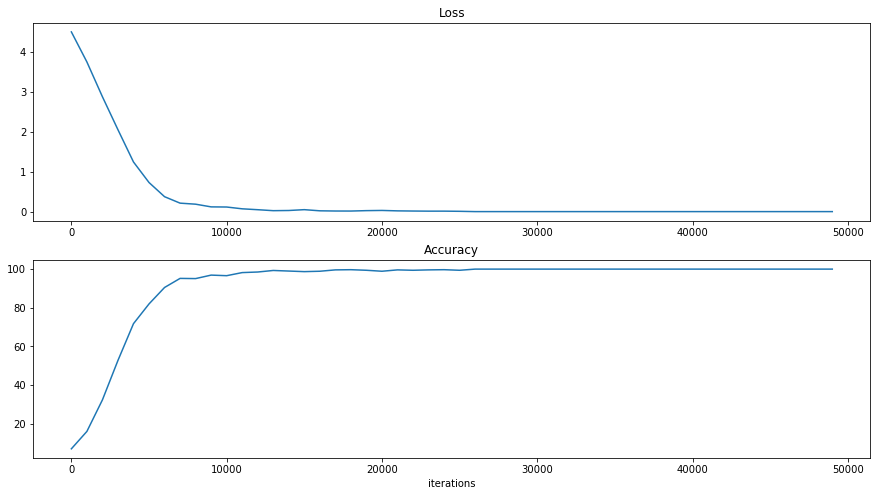

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(np.arange(0,50000, 1000), losses)
ax1.set_title('Loss')
ax2.plot(np.arange(0,50000, 1000), accuracies)
ax2.set_title('Accuracy')
ax2.set_xlabel('iterations')
plt.show()

In [35]:
next_word_prediction(path, n_input)

INFO:tensorflow:Restoring parameters from lstm_model/lstm-2-6
some excitement . he rushed down towards
 Predicted word: towards 
 Word from text: towards
the same trick , and again the
 Predicted word: the 
 Word from text: the
and some of them stopped with him
 Predicted word: him 
 Word from text: him
a little company and some excitement .
 Predicted word: . 
 Word from text: .
, and some of them stopped with
 Predicted word: with 
 Word from text: with
him for a considerable time . this
 Predicted word: this 
 Word from text: this
the village said : a liar will
 Predicted word: will 
 Word from text: will
louder than before . but this time
 Predicted word: time 
 Word from text: time
flock , and when the boy complained
 Predicted word: complained 
 Word from text: complained
will not be believed , even when
 Predicted word: when 
 Word from text: when


In [36]:
print(generate_fable(path, n_input))

INFO:tensorflow:Restoring parameters from lstm_model/lstm-2-6
came to his help . but shortly after this a wolf actually did come out from the forest , and began to worry the sheep, and the boy of course cried out wolf , wolf , still louder than before . but this time the villagers , who had been fooled twice before , thought the boy was again deceiving them , and nobody stirred to come to his help . so the wolf made a good meal off the boy's flock , and when the boy complained , the wise man of the village said : a liar will not be believed , even when he speaks the truth . this .


<font size="3" face="verdana" > <i> "There was once a young Shepherd Boy who tended his sheep at the foot of a mountain near a dark forest.

It was rather lonely for him all day, so he thought upon a plan by which he could get a little company and some excitement.
He rushed down towards the village calling out "Wolf, Wolf," and the villagers came out to meet him, and some of them stopped with him for a considerable time.
This pleased the boy so much that a few days afterwards he tried the same trick, and again the villagers came to his help.
But shortly after this a Wolf actually did come out from the forest, and began to worry the sheep, and the boy of course cried out "Wolf, Wolf," still louder than before.
But this time the villagers, who had been fooled twice before, thought the boy was again deceiving them, and nobody stirred to come to his help.
So the Wolf made a good meal off the boy's flock, and when the boy complained, the wise man of the village said:
"A liar will not be believed, even when he speaks the truth."  "</i> </font>.    







<div class='alert alert-warning'>
Just out of curiosity, and to verify that our hypotesis was correct, we tried out the same algorithm with a larger window. We notice how we reach 100% of accuracy, probably due to overfitting, which although leads to a perfect match with the story, followed by a last word which is only there to complete the 5 sentences required by the exercise.
</div>

## 3-Layers

We increase the number of LSTM layers, while maintaining the number of input words set to 3.

In [37]:
n_input=3
n_layers=3
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, 
                                  correct_pred, accuracy, path,
                                  epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.630550, Average Accuracy = 5.80%
['a', 'young', 'shepherd'] - [boy] vs [,]
Iter = 2000, Average Loss = 3.999914, Average Accuracy = 11.00%
['young', 'shepherd', 'boy'] - [who] vs [the]
Iter = 3000, Average Loss = 3.316382, Average Accuracy = 20.70%
['rather', 'lonely', 'for'] - [him] vs [before]
Iter = 4000, Average Loss = 2.717895, Average Accuracy = 32.00%
['he', 'thought', 'upon'] - [a] vs [.]
Iter = 5000, Average Loss = 1.819497, Average Accuracy = 53.50%
['company', 'and', 'some'] - [excitement] vs [excitement]
Iter = 6000, Average Loss = 1.640806, Average Accuracy = 60.20%
['some', 'excitement', '.'] - [he] vs [he]
Iter = 7000, Average Loss = 1.805542, Average Accuracy = 54.10%
['company', 'and', 'some'] - [excitement] vs [excitement]
Iter = 8000, Average Loss = 1.254132, Average Accuracy = 66.60%
['get', 'a', 'little'] - [company] vs [when]
Iter = 9000, Average Loss = 1.257069, Average Accuracy = 65.40%
['he', 'could', 'get'] - [a] vs

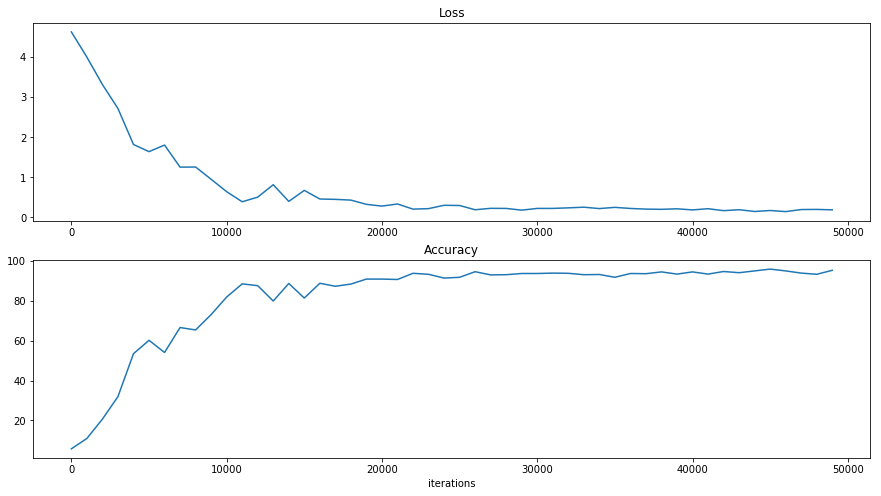

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(np.arange(0,50000, 1000), losses)
ax1.set_title('Loss')
ax2.plot(np.arange(0,50000, 1000), accuracies)
ax2.set_title('Accuracy')
ax2.set_xlabel('iterations')
plt.show()

In [41]:
next_word_prediction(path, n_input)

INFO:tensorflow:Restoring parameters from lstm_model/lstm-3-3
his help . but
 Predicted word: but 
 Word from text: so
this a wolf actually
 Predicted word: actually 
 Word from text: actually
. he rushed down
 Predicted word: down 
 Word from text: down
villagers came out to
 Predicted word: to 
 Word from text: to
to come to his
 Predicted word: his 
 Word from text: his
was once a young
 Predicted word: young 
 Word from text: young
boy so much that
 Predicted word: that 
 Word from text: that
, wolf , still
 Predicted word: still 
 Word from text: still
afterwards he tried the
 Predicted word: the 
 Word from text: the
out wolf , wolf
 Predicted word: wolf 
 Word from text: wolf


In [42]:
print(generate_fable(path, n_input))

INFO:tensorflow:Restoring parameters from lstm_model/lstm-3-3
boy was again deceiving them , and nobody stirred to come to his help . but the boy was course cried the and so much down the foot . the boy of course cried out wolf , wolf , still louder than before . but this time the villagers , who had been fooled twice before , thought the boy was course cried the and so much down the foot . the boy of course cried out wolf , wolf , still louder than before .


<div class='alert alert-warning'>
The result is close to the one obtained with only 2 LSTM layers, both in terms of accuracy and thhe predicted story.
</div>